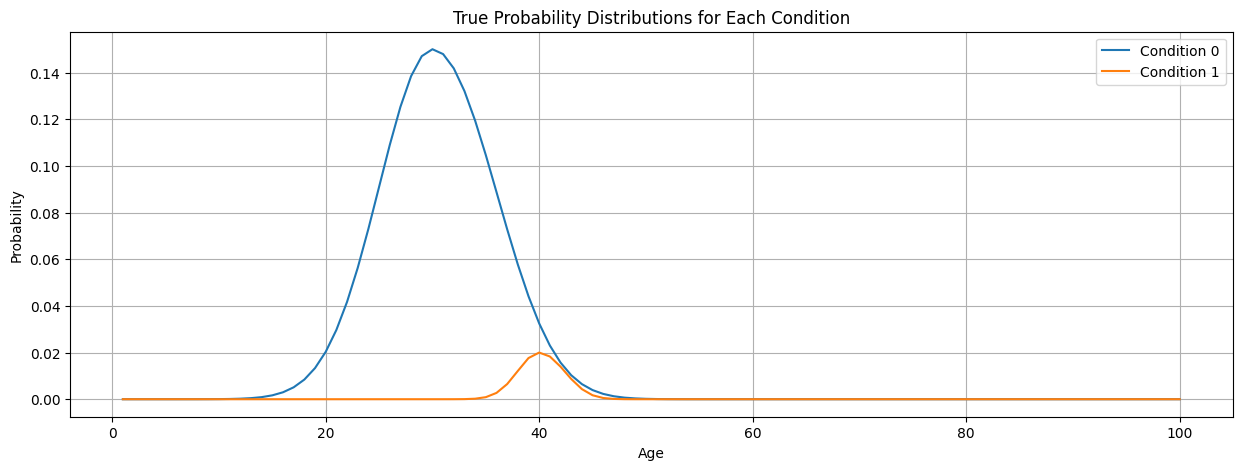

Validation loss components:
Validation loss components:
Validation loss components:
Validation loss components:
Validation loss components:
Epoch 5/20:
Training Loss: 0.7085
Validation Loss: 0.6956
Learning Rate: 0.050000

Validation loss components:
Validation loss components:
Validation loss components:
Validation loss components:
Validation loss components:
Epoch 10/20:
Training Loss: 0.7002
Validation Loss: 0.6509
Learning Rate: 0.025000

Validation loss components:
Validation loss components:
Validation loss components:
Validation loss components:
Validation loss components:
Epoch 15/20:
Training Loss: 0.6870
Validation Loss: 0.6568
Learning Rate: 0.025000

Validation loss components:
Validation loss components:
Validation loss components:
Validation loss components:
Validation loss components:
Epoch 20/20:
Training Loss: 0.6629
Validation Loss: 0.6487
Learning Rate: 0.006250



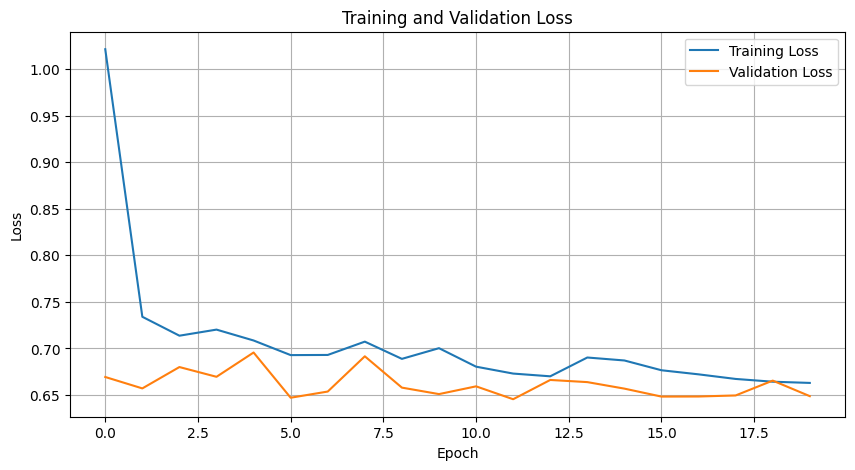

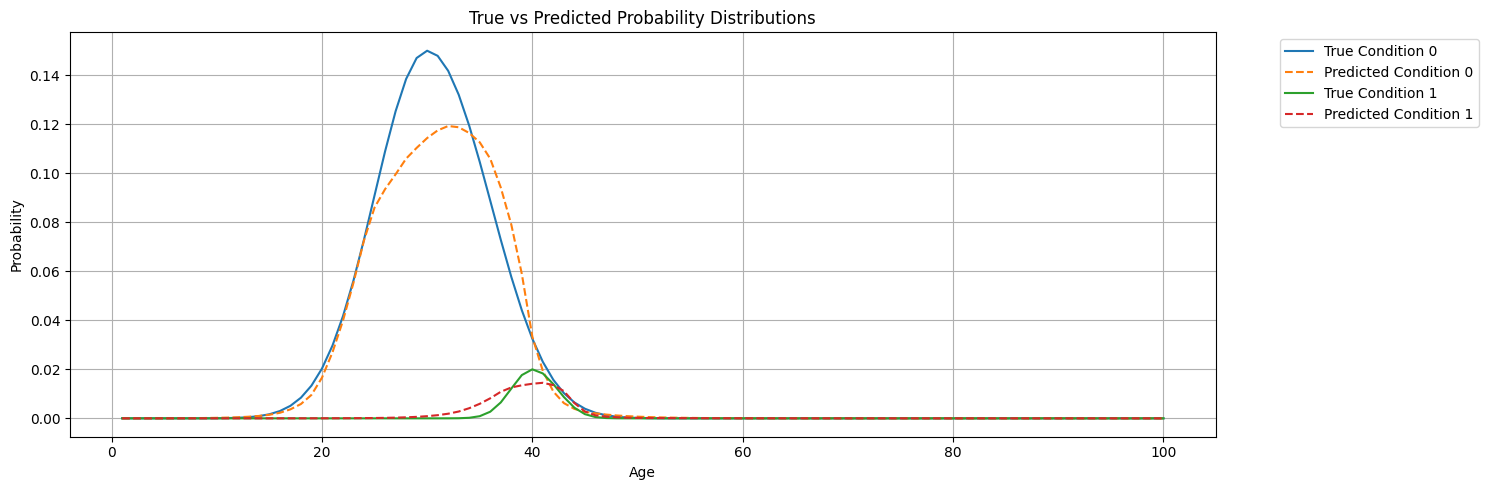


Final test set normalized entropy: 0.6487

Final test set normalized entropy CE : 0.0550

Final test set normalized entropy NE : 0.6487


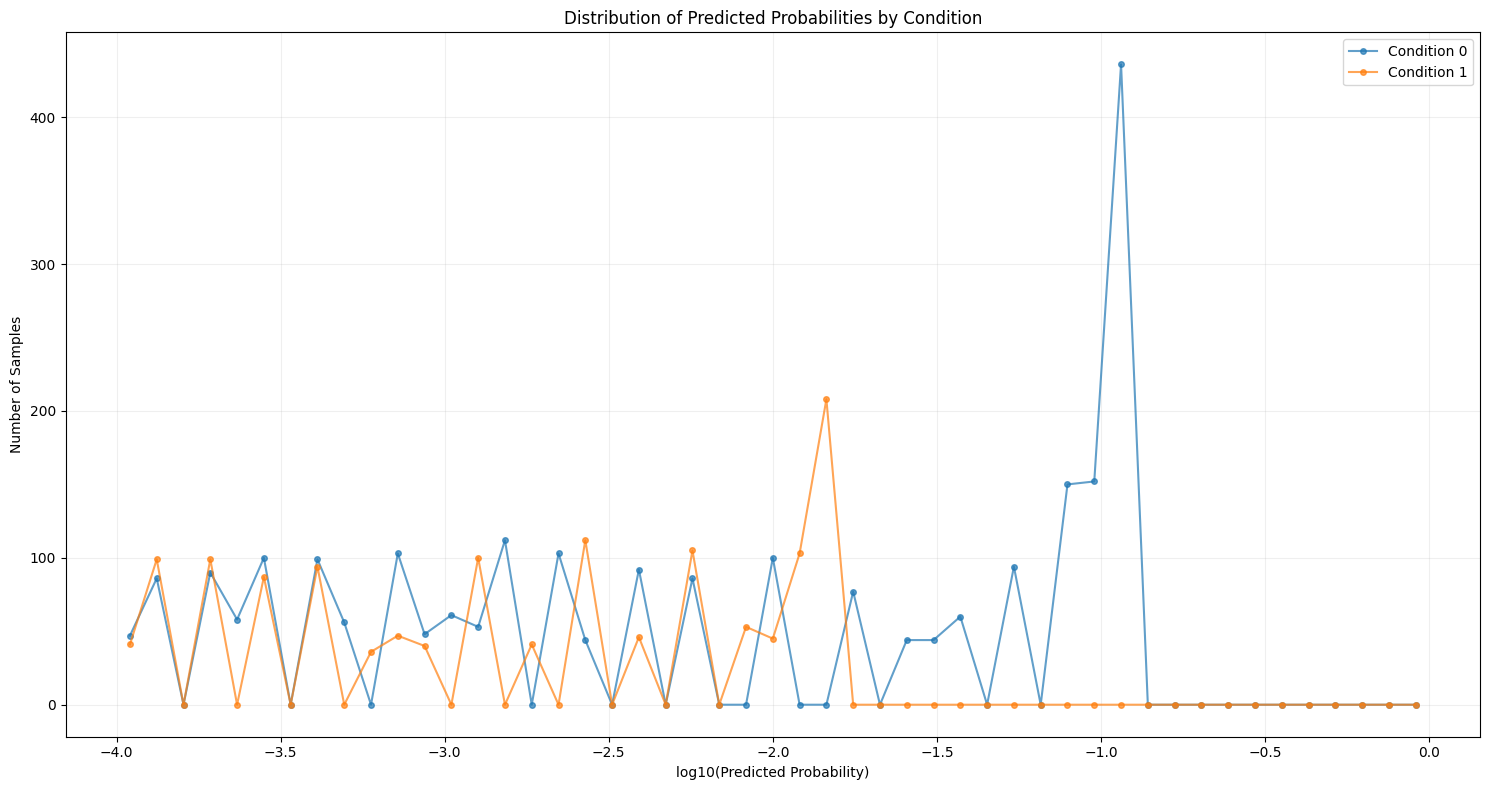

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Parameters
K = 2       # Number of conditions
T = int(100000/K)   # Total number of samples per condition (T * K should be 100000)

TOTAL_SAMPLES = T * K  # Total number of samples across all conditions
mu_list = [30, 40, 50, 60, 70]  # Different medians for each condition
std_list = [5, 2, 4, 6, 8]      # Different std for each condition
p_center_list = [0.15, 0.02, 0.15, 0.08, 0.12]  # Different peak probabilities
EMBEDDING_DIM = 8   # Dimension of condition embedding
N_EPOCHS = 20
BATCH_SIZE = 1000
TRAIN_SPLIT = 0.9
LEARNING_RATE = 0.0005
LEARNING_RATE = 0.05

def generate_skewed_gaussian(age, mu, std, p_center):
    """Generate probability using double-skewed Gaussian"""
    z = (age - mu) / std
    base_prob = p_center * np.exp(-0.5 * z ** 2)
    
    if age > mu:
        skew_factor = 1 + 0.15 * (z ** 2)
        base_prob *= skew_factor
    
    return min(base_prob, 1.0)

# Generate training data for all conditions
# Pre-allocate arrays
all_ages = np.zeros(TOTAL_SAMPLES, dtype=np.int32)
all_condition_ids = np.zeros(TOTAL_SAMPLES, dtype=np.int32)
all_labels = np.zeros(TOTAL_SAMPLES, dtype=np.int32)
all_true_probs = np.zeros(TOTAL_SAMPLES, dtype=np.float32)

# Fill arrays condition by condition
for condition_id in range(K):
    start_idx = condition_id * T
    end_idx = (condition_id + 1) * T
    
    # Generate ages
    ages = np.random.randint(1, 101, size=T)
    
    # Generate probabilities and labels
    probabilities = np.array([
        generate_skewed_gaussian(
            age, 
            mu_list[condition_id], 
            std_list[condition_id], 
            p_center_list[condition_id]
        ) for age in ages
    ])
    labels = np.random.binomial(n=1, p=probabilities)
    
    # Store in pre-allocated arrays
    all_ages[start_idx:end_idx] = ages
    all_condition_ids[start_idx:end_idx] = condition_id
    all_labels[start_idx:end_idx] = labels
    all_true_probs[start_idx:end_idx] = probabilities

# Calculate age statistics for normalization
age_mean = np.mean(all_ages)
age_std = np.std(all_ages)

# Plot true probability distributions for each condition
plt.figure(figsize=(15, 5))
age_range = np.arange(1, 101)

for condition_id in range(K):
    true_probs = [
        generate_skewed_gaussian(
            age, 
            mu_list[condition_id], 
            std_list[condition_id], 
            p_center_list[condition_id]
        ) for age in age_range
    ]
    plt.plot(age_range, true_probs, label=f'Condition {condition_id}')

plt.xlabel('Age')
plt.ylabel('Probability')
plt.title('True Probability Distributions for Each Condition')
plt.legend()
plt.grid(True)
plt.show()

class MedicalDataset(Dataset):
    def __init__(self, ages, condition_ids, labels, age_mean, age_std):
        self.ages = torch.FloatTensor((ages - age_mean) / age_std).reshape(-1, 1)
        self.condition_ids = torch.LongTensor(condition_ids)
        self.labels = torch.FloatTensor(labels).reshape(-1, 1)
        
    def __len__(self):
        return len(self.ages)
    
    def __getitem__(self, idx):
        return (self.ages[idx], self.condition_ids[idx]), self.labels[idx]

class ProbabilityNN(nn.Module):
    def __init__(self, num_conditions, embedding_dim, dropout_rate=0.2):
        super().__init__()
        
        # Embedding layer for condition IDs
        self.condition_embedding = nn.Embedding(num_conditions, embedding_dim)
        
        # Combined input size (normalized age + condition embedding)
        input_size = 1 + embedding_dim
        
        self.network = nn.Sequential(
            # First layer
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            # Second layer
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            # Third layer
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            # Output layer
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        age, condition_id = x
        # Get condition embeddings
        condition_emb = self.condition_embedding(condition_id)
        # Concatenate age and condition embedding
        combined_input = torch.cat([age, condition_emb], dim=1)
        return self.network(combined_input)

# Prepare data
dataset = MedicalDataset(all_ages, all_condition_ids, all_labels, age_mean, age_std)
train_size = int(TRAIN_SPLIT * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Initialize model and optimizer
model = ProbabilityNN(num_conditions=K, embedding_dim=EMBEDDING_DIM)
# Custom Normalized Entropy Loss
def normalized_entropy_loss(predictions, labels, reduction='mean'):
    eps = 1e-7
    predictions = torch.clamp(predictions, eps, 1 - eps)
    
    # Compute average prediction for the batch
    avg_prediction = (1 + labels.sum())/ labels.numel()
    
    # Compute cross entropy
    ce = -labels * torch.log2(predictions) - (1 - labels) * torch.log2(1 - predictions)
    
    # Compute denominator
    ne_denominator = -labels * torch.log2(avg_prediction) - \
                    (1 - labels) * torch.log2(1 - avg_prediction)
    
    # Compute NE
    ne = ce.sum() / ne_denominator.sum()
    
    if reduction == 'mean':
        return ne
    return ne



# cross entropy
def normalized_entropy_loss_ce(predictions, labels, reduction='mean'):
    eps = 1e-7
    predictions = torch.clamp(predictions, eps, 1 - eps)
    
    # Compute average prediction for the batch
    avg_prediction = (1 + labels.sum())/ labels.numel()
    
    # Compute cross entropy
    ce = -labels * torch.log2(predictions) - (1 - labels) * torch.log2(1 - predictions)
    
    return torch.mean(ce)


criterion = normalized_entropy_loss
#criterion = normalized_entropy_loss_ce
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# Training loop
plt.figure(figsize=(10, 5))
train_losses = []
val_losses = []

for epoch in range(N_EPOCHS):
    model.train()
    epoch_losses = []
    for batch_idx, ((age_batch, condition_batch), target_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model((age_batch, condition_batch))
        loss = criterion(output, target_batch)
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
    
    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, ((age_batch, condition_batch), target_batch) in enumerate(test_loader):
            output = model((age_batch, condition_batch))
            batch_loss = criterion(output, target_batch)
            val_loss += batch_loss.item()
            
            # Print detailed validation loss components for first batch
            if batch_idx == 0:
                print(f'Validation loss components:')
                _ = criterion(output, target_batch)  # This will trigger the print in the loss function
                
    val_loss /= len(test_loader)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Store losses
    avg_train_loss = np.mean(epoch_losses)
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch + 1}/{N_EPOCHS}:')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}\n')

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Generate predictions for all ages and conditions
plt.figure(figsize=(15, 5))
age_range = torch.FloatTensor((np.arange(1, 101) - age_mean) / age_std).reshape(-1, 1)

model.eval()
for condition_id in range(K):
    condition_ids = torch.full((100,), condition_id, dtype=torch.long)
    with torch.no_grad():
        predictions = model((age_range, condition_ids))
    
    # Plot true vs predicted distribution
    true_probs = [
        generate_skewed_gaussian(
            age, 
            mu_list[condition_id], 
            std_list[condition_id], 
            p_center_list[condition_id]
        ) for age in range(1, 101)
    ]
    
    plt.plot(range(1, 101), true_probs, 
             label=f'True Condition {condition_id}', 
             linestyle='-')
    plt.plot(range(1, 101), predictions.numpy(), 
             label=f'Predicted Condition {condition_id}', 
             linestyle='--')

plt.xlabel('Age')
plt.ylabel('Probability')
plt.title('True vs Predicted Probability Distributions')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print final test loss and generate prediction distribution
model.eval()
test_loss = 0
test_loss_ce = 0
test_loss_ne = 0
all_predictions = []
all_condition_ids = []

with torch.no_grad():
    for (age_batch, condition_batch), target_batch in test_loader:
        output = model((age_batch, condition_batch))
        test_loss += criterion(output, target_batch).item()
        test_loss_ce += normalized_entropy_loss_ce(output, target_batch).item()
        test_loss_ne += normalized_entropy_loss(output, target_batch).item()
        all_predictions.extend(output.numpy().flatten())
        all_condition_ids.extend(condition_batch.numpy().flatten())
    
test_loss /= len(test_loader)
print(f'\nFinal test set normalized entropy: {test_loss:.4f}')

test_loss_ce /= len(test_loader)
print(f'\nFinal test set normalized entropy CE : {test_loss_ce:.4f}')

test_loss_ne /= len(test_loader)
print(f'\nFinal test set normalized entropy NE : {test_loss_ne:.4f}')


# Compute normalized entropy loss on all training data
# print("\nComputing normalized entropy loss on full training dataset...")
# full_dataset = MedicalDataset(all_ages, all_condition_ids, all_labels, age_mean, age_std)
# full_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False)

# total_loss = 0
# num_batches = 0
# model.eval()
# with torch.no_grad():
#     for (age_batch, condition_batch), target_batch in full_loader:
#         output = model((age_batch, condition_batch))
#         batch_loss = criterion(output, target_batch)
#         total_loss += batch_loss.item()
#         num_batches += 1
#         if num_batches == 1:  # Print components for first batch
#             print("First batch components:")
#             _ = criterion(output, target_batch)  # This triggers the detailed print in loss function

# print(f"\nNormalized Entropy Loss on full dataset: {total_loss/num_batches:.4f}")

# Create probability distribution plot
plt.figure(figsize=(15, 8))
all_predictions = np.array(all_predictions)
all_condition_ids = np.array(all_condition_ids)

# Create log10 bins
log_bins = np.logspace(-4, 0, 50)  # Create 50 bins from 10^-4 to 10^0

for condition_id in range(K):
    condition_mask = all_condition_ids == condition_id
    condition_predictions = all_predictions[condition_mask]
    
    # Calculate histogram
    hist, _ = np.histogram(condition_predictions, bins=log_bins)
    
    # Plot at bin centers
    bin_centers = np.sqrt(log_bins[:-1] * log_bins[1:])  # Geometric mean of bin edges
    plt.plot(np.log10(bin_centers), hist, label=f'Condition {condition_id}', 
             marker='o', markersize=4, alpha=0.7)

plt.xlabel('log10(Predicted Probability)')
plt.ylabel('Number of Samples')
plt.title('Distribution of Predicted Probabilities by Condition')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()